In [ ]:
!pip install optuna

In [ ]:
!pip install matplotlib

In [ ]:
!pip install -U ydata-profiling

In [ ]:
!pip install shap

In [ ]:
!pip install catboost

In [ ]:
!pip install --upgrade matplotlib

In [ ]:
!pip install permetrics

In [ ]:
!pip install category_encoders

In [9]:
import pandas as pd
import re
import phik
from phik import report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import shap
import optuna
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, mean_squared_log_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from permetrics.regression import RegressionMetric
from numpy import array
from joblib import load, dump
from ydata_profiling import ProfileReport
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

**Загрузка данных и очистка**

Произведен парсинг данных с помощью API HH.ru

In [10]:
uni_data = pd.read_csv('uni_data.csv')

In [11]:
uni_data = uni_data.drop('Unnamed: 0', axis=1)

In [12]:
uni_data.head()

,key_skills,area,schedule,experience,salary_from,salary_to,currency,created_at,employment,languages,professional_roles
0,"Linux, SQL, Unix",Тверь,Сменный график,От 1 года до 3 лет,NaN,200000.0,RUR,2024-08-22T13:08:27+0300,Полная занятость,NaN,Системный инженер
1,"BPMN, EPC, UML, MS Dynamics CRM, Power BI, SQL...",Москва,Удаленная работа,От 1 года до 3 лет,NaN,150000.0,RUR,2024-08-22T13:08:27+0300,Полная занятость,Английский,Бизнес-аналитик
2,NaN,Москва,Полный день,От 3 до 6 лет,NaN,370000.0,RUR,2024-08-22T13:08:27+0300,Полная занятость,NaN,Аналитик
3,"Работа в команде, Работа с базами данных, Базы...",Симферополь,Полный день,От 3 до 6 лет,35000.0,NaN,RUR,2024-08-22T13:08:27+0300,Полная занятость,NaN,Системный администратор
4,"PostgreSQL, Clickhouse, Numpy, pandas, Kuberne...",Москва,Полный день,От 3 до 6 лет,NaN,350000.0,RUR,2024-08-22T13:08:27+0300,Полная занятость,NaN,Дата-сайентист


Определить тип данных в каждом столбце

In [13]:
uni_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469 entries, 0 to 7468
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key_skills          5280 non-null   object 
 1   area                7469 non-null   object 
 2   schedule            7314 non-null   object 
 3   experience          7469 non-null   object 
 4   salary_from         5169 non-null   float64
 5   salary_to           3586 non-null   float64
 6   currency            6195 non-null   object 
 7   created_at          7469 non-null   object 
 8   employment          7314 non-null   object 
 9   languages           622 non-null    object 
 10  professional_roles  7314 non-null   object 
dtypes: float64(2), object(9)
memory usage: 642.0+ KB


Определить количество отсутствующих значений

In [14]:
uni_data.isna().sum()

,0
key_skills,2189
area,0
schedule,155
experience,0
salary_from,2300
salary_to,3883
currency,1274
created_at,0
employment,155
languages,6847


Привести данные к необходимым типам

In [15]:
uni_data['salary_from'] = pd.to_numeric(uni_data['salary_from'], errors='coerce')
uni_data['salary_to'] = pd.to_numeric(uni_data['salary_to'], errors='coerce')

In [16]:
df_copy = uni_data.copy()

Берем среднее арифметическое от опыта и диапазона зарплат

In [17]:
def clean_exp(exp):
    try:
        if pd.isna(exp):
            return None

        years = re.findall(r'\d+', exp)
        exp_cleaned = None

        if len(years) == 1:
            exp_cleaned = int(years[0])
        elif len(years) == 2:
            exp_cleaned = (int(years[0]) + int(years[1])) / 2
        elif len(years) == 0:
            exp_cleaned = 0

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    return exp_cleaned

In [18]:
def clean_salary(df):
    df.loc[(~df['salary_from'].isna()) & (~df['salary_to'].isna()), 'salary'] = (df['salary_from'] + df['salary_to']) / 2

    df.loc[(~df['salary_from'].isna()) & (df['salary_to'].isna()), 'salary'] = df['salary_from']
    df.loc[(df['salary_from'].isna()) & (~df['salary_to'].isna()), 'salary'] = df['salary_to']
    df = df.drop(['salary_to', 'salary_from'], axis=1)
    return df

In [19]:
df_copy['salary'] = ''

In [20]:
df_copy['key_skills'] = df_copy['key_skills'].str.lower()
df_copy['experience'] = df_copy['experience'].apply(clean_exp)
df_copy = clean_salary(df_copy)

In [21]:
df_copy['salary'] = pd.to_numeric(df_copy['salary'], errors='coerce')

In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469 entries, 0 to 7468
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key_skills          5280 non-null   object 
 1   area                7469 non-null   object 
 2   schedule            7314 non-null   object 
 3   experience          7469 non-null   float64
 4   currency            6195 non-null   object 
 5   created_at          7469 non-null   object 
 6   employment          7314 non-null   object 
 7   languages           622 non-null    object 
 8   professional_roles  7314 non-null   object 
 9   salary              6195 non-null   float64
dtypes: float64(2), object(8)
memory usage: 583.6+ KB


Признак - названия профессий будут важны для группировки навыков по процессиям. Зарплата будет таргетом.  Необходимо почистить отсутствующие значения в этих столбцах.

In [23]:
df_copy = df_copy.dropna(subset='salary')
df_copy = df_copy.dropna(subset='professional_roles')

In [24]:
df_copy.isna().sum()

,0
key_skills,1876
area,0
schedule,0
experience,0
currency,0
created_at,0
employment,0
languages,5696
professional_roles,0
salary,0


Таргетная переменная - зарплата представлена в разных валютах. Это создает необъективную оценку и выбросы.  Переводим в русские рубли,  учитываем курс валют на дату создания вакансии.  Используем API Центрального Банка.

In [25]:
df_copy['created_at'] = [date[:10] for date in df_copy['created_at']]

In [26]:
def to_rur(row):
    if row['currency'] != 'RUR':
        date = row['created_at']
        year = date[:4]
        month = date[5:7]
        day = date[8:10]

        url = f'http://www.cbr.ru/scripts/XML_daily.asp?date_req={day}/{month}/{year}'
        df = pd.read_xml(url, encoding='cp1251')
        if row['currency'] == 'BYR':
            row['currency'] = 'BYN'
        value = df[df['CharCode'] == row['currency']]['Value']
        if not value.empty:
            value = value.item().replace(',', '.')
            row['salary'] *= float(value)
            row['currency'] = 'RUR'
    return row

In [27]:
df_copy = df_copy.apply(to_rur, axis=1)

Валюта и дата создания вакансии больше не нужны для дальнейшего анализа.

In [28]:
df_copy = df_copy.drop(['currency', 'created_at'], axis=1)

Пропуски в столбце с языками составляют более 15%.

In [29]:
df_copy = df_copy.drop('languages', axis=1)

Удаляем дубликаты при их наличии

In [30]:
df_copy = df_copy.drop_duplicates()

In [31]:
df_copy.head()

,key_skills,area,schedule,experience,employment,professional_roles,salary
0,"linux, sql, unix",Тверь,Сменный график,2.0,Полная занятость,Системный инженер,200000.0
1,"bpmn, epc, uml, ms dynamics crm, power bi, sql...",Москва,Удаленная работа,2.0,Полная занятость,Бизнес-аналитик,150000.0
2,NaN,Москва,Полный день,4.5,Полная занятость,Аналитик,370000.0
3,"работа в команде, работа с базами данных, базы...",Симферополь,Полный день,4.5,Полная занятость,Системный администратор,35000.0
4,"postgresql, clickhouse, numpy, pandas, kuberne...",Москва,Полный день,4.5,Полная занятость,Дата-сайентист,350000.0


Во время парсинга были отобраны вакансии, не связанные с DS. Также столбец professional roles позоляет удобно сгруппировать профессии для дальнейшей обработки навыков.

In [32]:
roles_to_filter = [
    'Дата-сайентист',
    'Бизнес-аналитик',
    'Аналитик',
    'BI-аналитик, аналитик данных',
    'Системный аналитик',
    'Продуктовый аналитик',
    'Маркетолог-аналитик'
]

filtered_df = df_copy[df_copy['professional_roles'].isin(roles_to_filter)]

По результатам предварительного анализа необходима визуализация

In [33]:
ProfileReport(filtered_df, title='My Report')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Признак key_skills будет обрабатан далее. Будет собран словарь синонимов навыков и отобраны уникальные навыки. Признаки будут закодированы. Очистим от отсутствующих значений



In [34]:
filtered_df = filtered_df.dropna(subset='key_skills')

Рассчет ключевых статистик для каждого типа данных

In [35]:
filtered_df.describe(include='all')

,key_skills,area,schedule,experience,employment,professional_roles,salary
count,3539,3539,3539,3539.000000,3539,3539,3.539000e+03
unique,2953,182,5,NaN,4,7,NaN
top,"анализ данных, sql, аналитическое мышление, ра...",Москва,Полный день,NaN,Полная занятость,Аналитик,NaN
freq,38,1385,2373,NaN,3250,1854,NaN
mean,NaN,NaN,NaN,2.340492,NaN,NaN,4.207946e+06
std,NaN,NaN,NaN,1.551382,NaN,NaN,5.590248e+07
min,NaN,NaN,NaN,0.000000,NaN,NaN,6.000000e+01
25%,NaN,NaN,NaN,2.000000,NaN,NaN,7.500000e+04
50%,NaN,NaN,NaN,2.000000,NaN,NaN,1.140000e+05
75%,NaN,NaN,NaN,4.500000,NaN,NaN,2.000000e+05


Рассмотрим распределения признаков и удалим выбросы

К выбросам чувствительны коэффициенты корреляции

{'whiskers': [<matplotlib.lines.Line2D at 0x7f046c4176a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f046c462800>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f046c462290>],
 'medians': [<matplotlib.lines.Line2D at 0x7f046c463f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f046c460850>],
 'means': []}

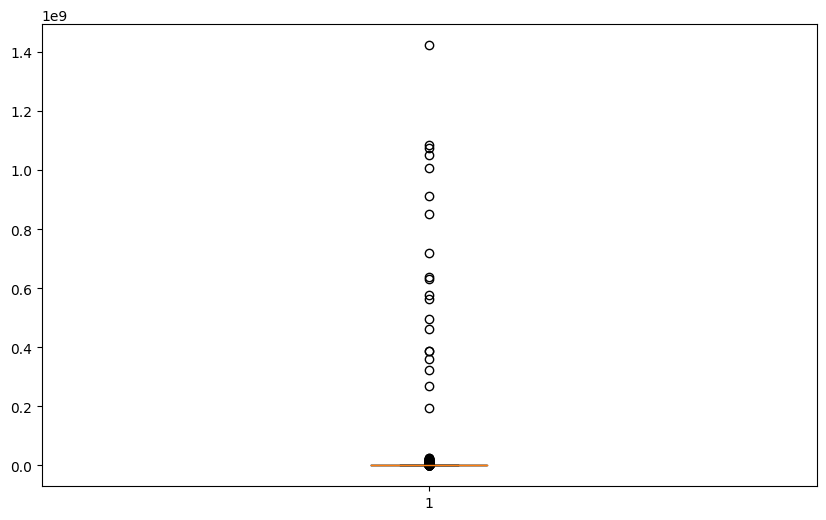

In [36]:
fig = plt.figure(figsize=(10,6))
plt.boxplot(filtered_df['salary'])

In [37]:
q_high = filtered_df.salary.quantile(0.915)
q_low = filtered_df.salary.quantile(0.085)
clear_data = filtered_df[(filtered_df.salary < q_high) & (filtered_df.salary > q_low)]
print(f"До удаления выбросов {filtered_df.shape[0]}")
print(f"После удаления выбросов {clear_data.shape[0]}")
print(f"Удалились данные {filtered_df.shape[0] - clear_data.shape[0]}")

До удаления выбросов 3539
После удаления выбросов 2903
Удалились данные 636


{'whiskers': [<matplotlib.lines.Line2D at 0x7f046c4cfca0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f046c4cf7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f046c4ce110>],
 'medians': [<matplotlib.lines.Line2D at 0x7f046c4ceb60>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f046c4ce9e0>],
 'means': []}

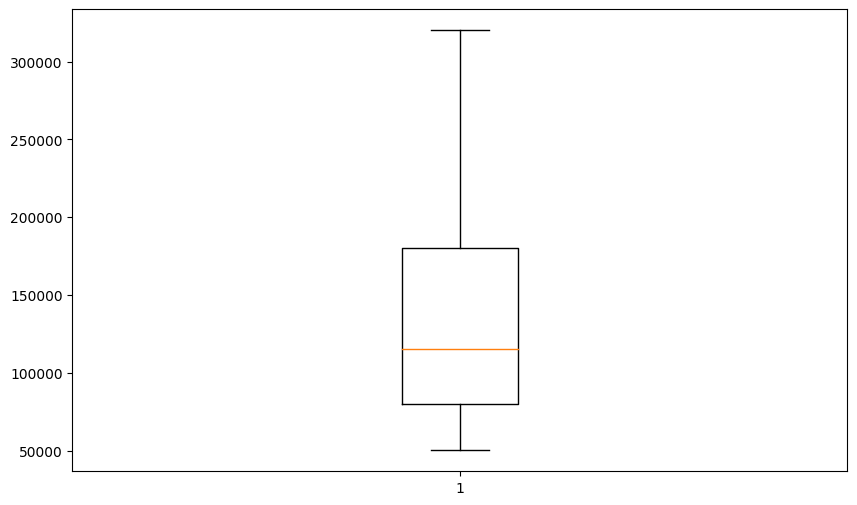

In [38]:
fig = plt.figure(figsize=(10,6))
plt.boxplot(clear_data['salary'])

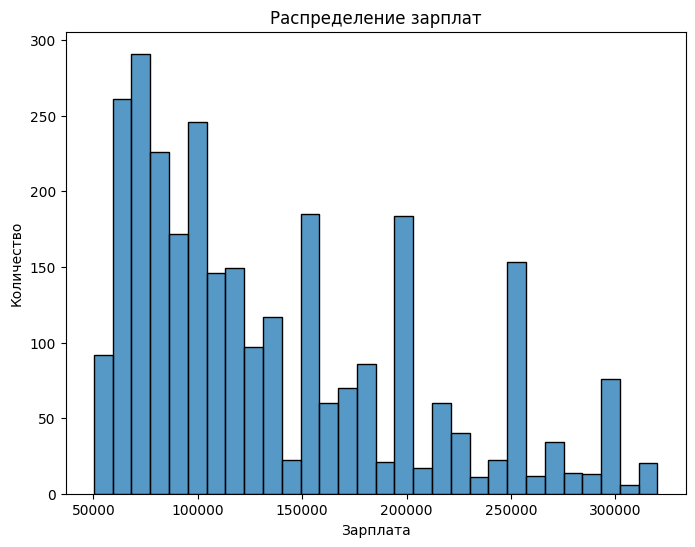

In [39]:
plt.figure(figsize=(8, 6))
sns.histplot(clear_data['salary'], bins=30, kde=False)
plt.title('Распределение зарплат')
plt.xlabel('Зарплата')
plt.ylabel('Количество')
plt.show()

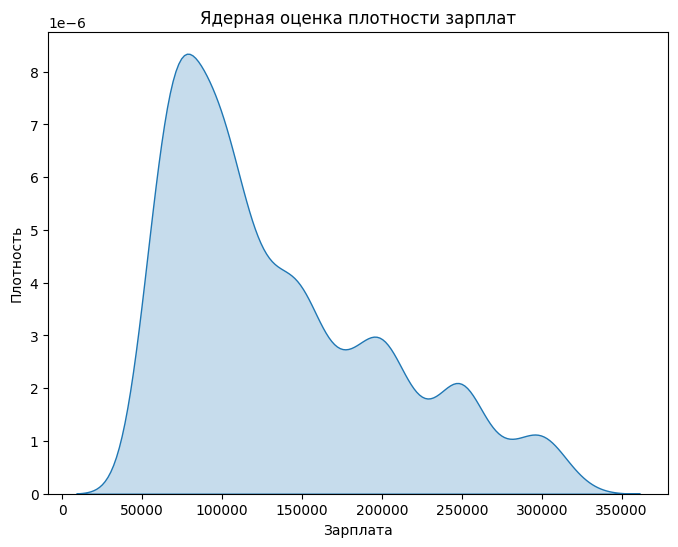

In [40]:
plt.figure(figsize=(8, 6))
sns.kdeplot(clear_data['salary'], shade=True)
plt.title('Ядерная оценка плотности зарплат')
plt.xlabel('Зарплата')
plt.ylabel('Плотность')
plt.show()

In [41]:
profs = []
for prof in clear_data['professional_roles']:
    if isinstance(prof, str):
        profs.append(prof)

prof_counts = Counter(profs)

df_profs_counts = pd.DataFrame(prof_counts.items(), columns=['Job', 'Frequency']).sort_values(by='Frequency', ascending=False)
df_profs_counts

,Job,Frequency
1,Аналитик,1487
0,Бизнес-аналитик,482
6,Системный аналитик,442
2,"BI-аналитик, аналитик данных",303
3,Дата-сайентист,104
4,Продуктовый аналитик,77
5,Маркетолог-аналитик,8


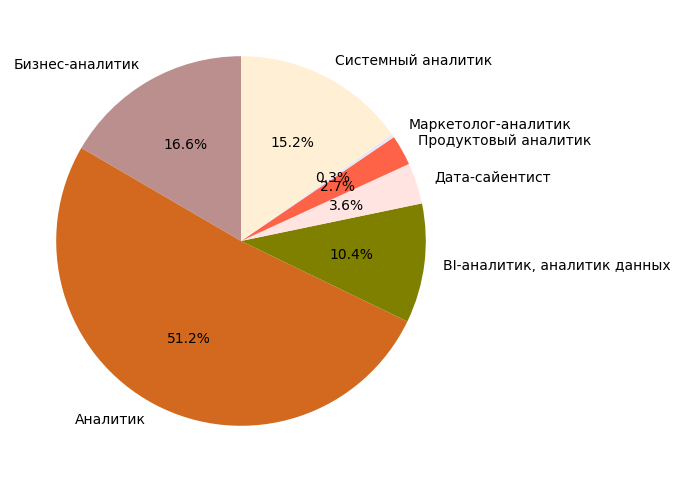

In [42]:
fig = plt.figure(figsize=(10,6))
colors = ['rosybrown', 'chocolate', 'olive', 'mistyrose', 'tomato', 'lavender', 'papayawhip']
plt.pie(prof_counts.values(), colors=colors, labels=prof_counts.keys(), startangle=90, autopct='%.1f%%')
plt.show()

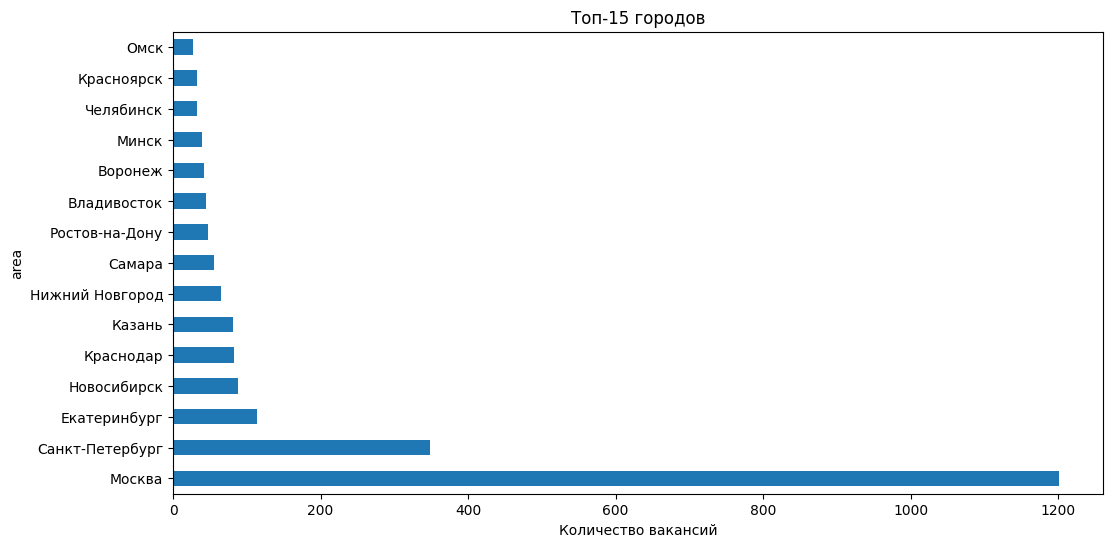

In [43]:
plt.figure(figsize=(12,6))
clear_data["area"].value_counts().nlargest(15).plot(kind='barh')
plt.title('Топ-15 городов')
plt.xlabel('Количество вакансий')
plt.show()

Распределение графика работы, опыта работы, занятости

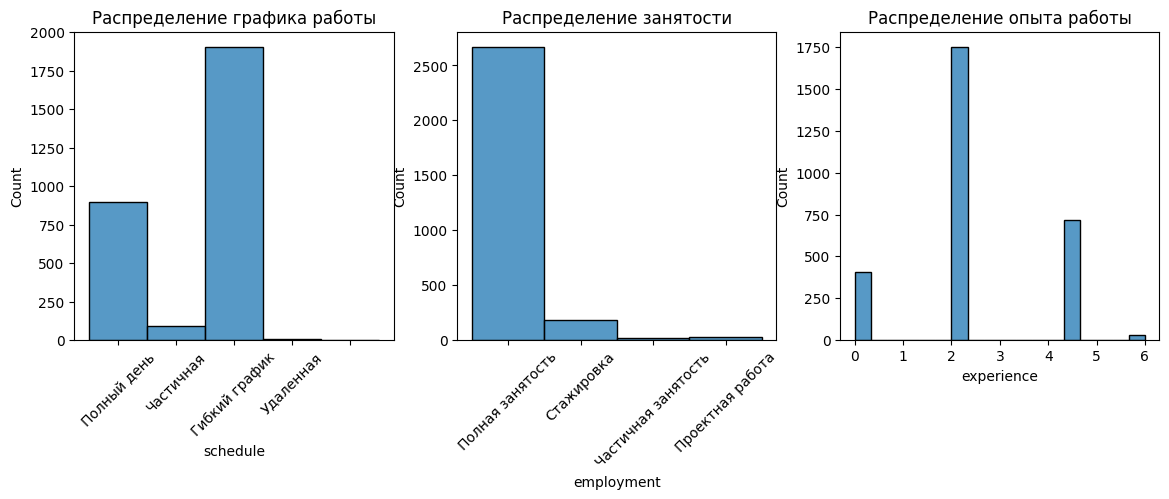

In [44]:
fig = plt.figure()
fig.tight_layout()
fig.set_size_inches(14, 4)
ax_1 = fig.add_subplot(131)
sns.histplot(clear_data, x='schedule')
ax_1.set_xticklabels(['Полный день', 'Частичная', 'Гибкий график', 'Удаленная'], rotation=45)

ax_2 = fig.add_subplot(132)
ax_2 = sns.histplot(clear_data, x='employment')
ax_2.set_xticklabels(['Полная занятость', 'Стажировка', 'Частичная занятость', 'Проектная работа'], rotation=45)

ax_3 = fig.add_subplot(133)
ax_3 = sns.histplot(clear_data, x='experience')

ax_1.set(title = 'Распределение графика работы')
ax_2.set(title = 'Распределение занятости')
ax_3.set(title = 'Распределение опыта работы')

plt.show()

Распределение графика работы, названия работы, занятости от таргетной переменной

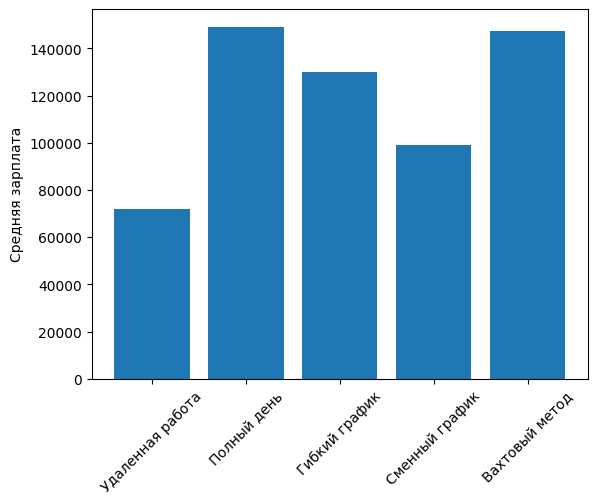

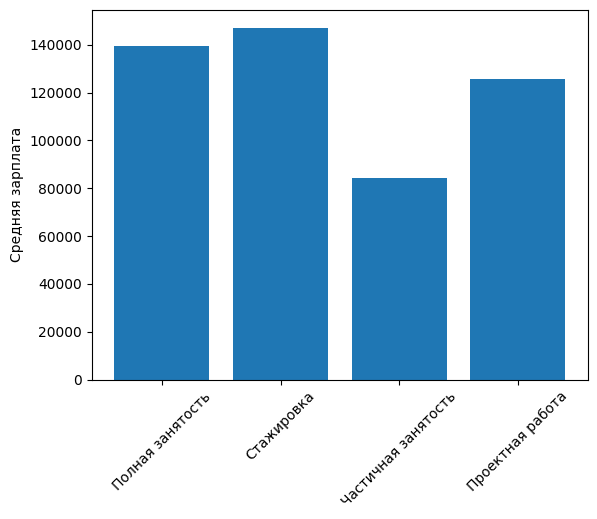

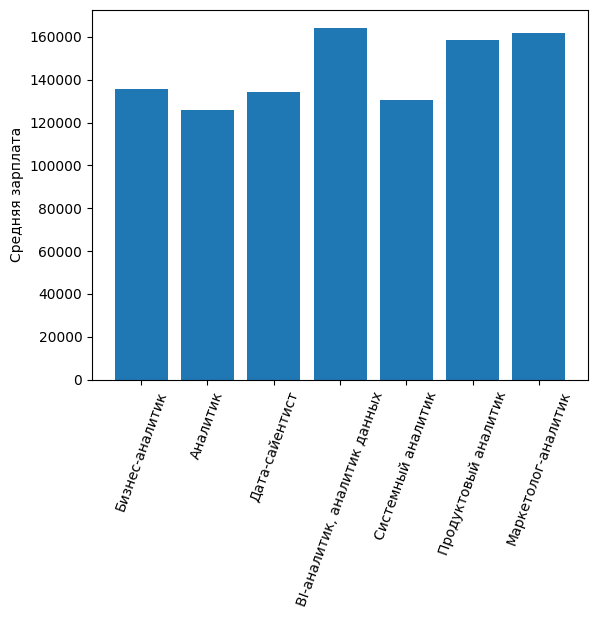

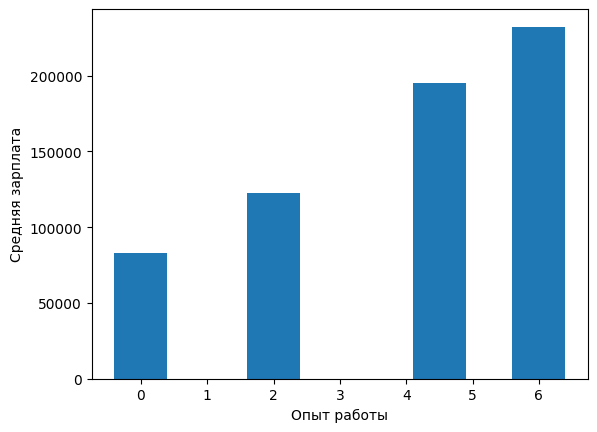

In [45]:
main = clear_data.groupby('schedule')['salary'].mean()

fig, ax = plt.subplots()
ax.bar(main.index, main)

ax.set_xticks(range(len(main.index)))
ax.set_xticklabels(['Удаленная работа', 'Полный день', 'Гибкий график',
       'Сменный график', 'Вахтовый метод'], rotation=45)
ax.set_ylabel('Средняя зарплата')

main_2 = clear_data.groupby('employment')['salary'].mean()

fig, ax = plt.subplots()
ax.bar(main_2.index, main_2)

ax.set_xticks(range(len(main_2.index)))
ax.set_xticklabels(['Полная занятость', 'Стажировка', 'Частичная занятость',
       'Проектная работа'], rotation=45)
ax.set_ylabel('Средняя зарплата')

main_3 = clear_data.groupby('professional_roles')['salary'].mean()

fig, ax = plt.subplots()
ax.bar(main_3.index, main_3)

ax.set_xticks(range(len(main_3.index)))
ax.set_xticklabels(['Бизнес-аналитик', 'Аналитик', 'Дата-сайентист',
       'BI-аналитик, аналитик данных', 'Системный аналитик',
       'Продуктовый аналитик', 'Маркетолог-аналитик'], rotation=70, fontsize=10)
ax.set_ylabel('Средняя зарплата')

main_4 = clear_data.groupby('experience')['salary'].mean()

fig, ax = plt.subplots()
ax.bar(main_4.index, main_4)
ax.set_xlabel('Опыт работы')
ax.set_ylabel('Средняя зарплата')

plt.show()

Эмпирически установлено, что ошибка больше, когда CatBoost сам обрабатывает категориальные признаки. Качество было лучше при ручном енкодинге признаков

Рассмотрим навыки для каждой профессии отдельно

In [46]:
data_bi = clear_data[clear_data['professional_roles'] == 'BI-аналитик, аналитик данных']
data_anal = clear_data[clear_data['professional_roles'] == 'Аналитик']
data_bus = clear_data[clear_data['professional_roles'] == 'Бизнес-аналитик']
data_sci = clear_data[clear_data['professional_roles'] == 'Дата-сайентист']
data_prod = clear_data[clear_data['professional_roles'] == 'Продуктовый аналитик']
data_sys = clear_data[clear_data['professional_roles'] == 'Системный аналитик']
data_mar = clear_data[clear_data['professional_roles'] == 'Маркетолог-аналитик']

In [47]:
clear_data.head()

,key_skills,area,schedule,experience,employment,professional_roles,salary
1,"bpmn, epc, uml, ms dynamics crm, power bi, sql...",Москва,Удаленная работа,2.0,Полная занятость,Бизнес-аналитик,150000.0
9,"коммуникабельность, системность, обучаемость, ...",Москва,Гибкий график,2.0,Полная занятость,Аналитик,90000.0
15,"sql, базы данных, python, power bi, ms sql, ap...",Калининград,Полный день,2.0,Полная занятость,"BI-аналитик, аналитик данных",80000.0
33,"power bi, ms excel, социологические исследования",Москва,Полный день,0.0,Полная занятость,"BI-аналитик, аналитик данных",60000.0
34,"python, pandas, numpy, scikit-learn, tensorflo...",Санкт-Петербург,Полный день,2.0,Полная занятость,Аналитик,120000.0


In [48]:
def ecd_skills(df, skills):
    df['key_skills'] = df['key_skills'].fillna('')
    df['key_skills'] = df['key_skills'].apply(lambda x: [skill.strip() for skill in x.split(',')])
    for skill in skills:
        df[skill] = df['key_skills'].apply(lambda x: 1 if skill in x else 0)
    return df

In [49]:
def freq_skills(df):
    skills = []
    for entry in df['key_skills']:
        if isinstance(entry, str):
            skills.extend([skill.strip().lower() for skill in entry.replace(';', ',').split(',')])

    skill_counts = Counter(skills)

    df_skill_counts = pd.DataFrame(skill_counts.items(), columns=['Skill', 'Frequency']).sort_values(by='Frequency', ascending=False)

    return df_skill_counts

In [50]:
enc_skills = []
def clean_skills(skills_list, *args):
    skills_list.remove(*args)
    enc_skills.extend(skills_list)
    return enc_skills

**Считаем навыки редкими, если они встречаются реже, чем 5% от максимальной частоты**

In [51]:
freq_bi = freq_skills(data_bi)
freq_anal = freq_skills(data_anal)
freq_bus = freq_skills(data_bus)
freq_sci = freq_skills(data_sci)
freq_mar = freq_skills(data_mar)
freq_prod = freq_skills(data_prod)
freq_sys = freq_skills(data_sys)

In [52]:
freq_bi = freq_bi[freq_bi['Frequency'] > 9]

In [53]:
freq_anal = freq_anal[freq_anal['Frequency'] > 19]

In [54]:
freq_bus = freq_bus[freq_bus['Frequency'] > 10]

In [55]:
freq_sci = freq_sci[freq_sci['Frequency'] > 5]

In [56]:
freq_mar

,Skill,Frequency
12,маркетинговые исследования,4
13,маркетинговый анализ,3
1,аналитические исследования,2
2,конкурентная аналитика,2
14,ms powerpoint,2
3,анализ бизнес показателей,2
0,market research,1
4,работа с большим объемом информации,1
8,python,1
5,навыки презентации,1


In [57]:
freq_prod = freq_prod[freq_prod['Frequency'] > 1]

In [58]:
freq_sys = freq_sys[freq_sys['Frequency'] > 1]

**Находим синонимы выражений и приводим навыки к единому виду**

In [59]:
syn_dict = {
    'анализ продаж': 'аналитика продаж',
    'анализ конкурентной среды': 'конкурентная аналитика',
    'big data': 'большие данные',
    'работа с большим объемом информации': 'большие данные',
    'bi': 'ms power bi',
    'power bi': 'ms power bi',
    'power point': 'ms powerpoint',
    'machine learning': 'машинное обучение',
    'классическое машинное обучение': 'машинное обучение',
    'математическая статистика': 'статистика',
    'статистический анализ': 'статистика',
    'databases': 'базы данных',
    'работа с базами данных': 'базы данных',
    'опыт работы с базами данных': 'базы данных',
    'аналитический склад ума': 'аналитическое мышление',
    'подготовка отчетов': 'аналитические отчеты',
    'формирование аналитической отчетности': 'аналитические отчеты',
    'data analysis': 'анализ данных',
    'сбор и анализ информации': 'анализ данных',
    'аналитические исследования': 'анализ данных',
    'системное мышление': 'системный анализ',
    'маркетинговая стратегия': 'маркетинговое планирование',
    'анализ бизнес показателей': 'бизнес-анализ',
    'анализ бизнес-процессов': 'бизнес-анализ',
    'описание бизнес-процессов': 'бизнес-анализ',
    'маркетинговые исследования': 'маркетинговый анализ',
    'agile product management': 'agile',
    'проведение презентаций': 'навыки презентации',
    'eda': 'анализ данных'}

words_2_del = ['', 'работа в команде', 'грамотная речь', 'обучение и развитие', 'коммуникабельность', 'системность',
               'обучаемость', 'оперативность', 'нацелен на результат', 'удаленная работа', 'управление командой', 'работа в команде	',
               'умение работать в коллективе', 'пользователь пк', 'точность и внимательность к деталям', 'ответственность']

def replace_synonyms(col, d):
    for i, line in enumerate(col):
        if isinstance(line, str):
            new_line = []
            words = [word.strip() for word in line.replace(';', ',').split(',')]
            new_line = [d[word] if word in d else word for word in words]
            new_line = [word for word in new_line if word not in words_2_del]
        col[i] = ','.join(new_line)
    return col

clear_data['key_skills'] = replace_synonyms(clear_data['key_skills'], syn_dict)

In [60]:
pattern = re.compile(r'\b(?:' + '|'.join(re.escape(key) for key in syn_dict.keys()) + r')\b', re.IGNORECASE)

def replace_synonyms(text, pattern, syn_dict):
    if isinstance(text, str):
        def synonym_replacer(match):
            found_word = match.group(0).lower()
            return syn_dict.get(found_word, found_word)

        replaced_text = re.sub(pattern, synonym_replacer, text)

        words = replaced_text.split()
        unique_words = list(dict.fromkeys(words))
        return ' '.join(unique_words)

    return text

clear_data['key_skills'] = clear_data['key_skills'].apply(lambda x: replace_synonyms(x, pattern, syn_dict))

In [61]:
words_2_del = ['', 'работа в команде', 'грамотная речь', 'обучение и развитие', 'коммуникабельность', 'системность',
               'обучаемость', 'оперативность', 'нацелен на результат', 'удаленная работа', 'управление командой',
               'работа в команде', 'умение работать в коллективе', 'пользователь пк',
               'точность и внимательность к деталям', 'ответственность', 'умение принимать решения', 'командообразование']

pattern = re.compile(r'\b(?:' + '|'.join(re.escape(word) for word in words_2_del if word) + r')\b', re.IGNORECASE)

def clean_text(text, pattern):
    if isinstance(text, str):
        cleaned_text = re.sub(pattern, '', text)
        cleaned_text = re.sub(r'\s{2,}', ' ', cleaned_text).strip()
        return cleaned_text
    return text

clear_data['key_skills'] = clear_data['key_skills'].apply(lambda x: clean_text(x, pattern))

In [62]:
def get_skills(df):
    skill_list = []
    for skills in df['Skill']:
        if isinstance(skills, str):
            skill_list.extend([skill.strip().lower() for skill in skills.replace(';', ',').split(',')])
    final_skills = list(set(skill_list))
    return final_skills

In [63]:
all_skills = (
    get_skills(freq_bi) +
    get_skills(freq_anal) +
    get_skills(freq_bus) +
    get_skills(freq_sci) +
    get_skills(freq_mar) +
    get_skills(freq_prod) +
    get_skills(freq_sys)
)

In [64]:
all_skills = list(set(all_skills))

In [65]:
d_w = ['консультирование', 'организаторские навыки', 'дистанционное обучение', 'управление требованиями', 'деловая переписка', 'техническое обслуживание', 'обучение и развитие', 'системный подход', 'английский язык', 'навыки переговоров', 'программы лояльности', 'ориентация на результат', 'техническая поддержка', 'сбор требований', 'коммуникабельность', 'деловое общение', 'умение работать в коллективе', 'ведение переговоров', 'ответственность', 'контроль выполнения задач', 'работа в команде', 'управление командой', 'деловая коммуникация', 'обучение персонала', 'обучение', 'протоколами связи и сенсорами', 'работа в условиях многозадачности', 'техническое задание', 'точность и внимательность к деталям', 'управление проектами', '', 'удаленная работа', 'планирование карьеры', 'сопровождение клиентов', 'тайм-менеджмент', 'грамотная речь']
for i in d_w:
  if i in all_skills:
    all_skills.remove(i)

In [66]:
ecd_data = clear_data.copy()
ecd_skills(ecd_data, all_skills)

,key_skills,area,schedule,experience,employment,professional_roles,salary,dax,scada,ui/ux,...,ms excel,er,node.js,анализ требований,конкурентная аналитика,анализ рынка,clickhouse,внедрение продукта,аналитические отчеты,автоматизация процессов
1,[],Москва,Удаленная работа,2.0,Полная занятость,Бизнес-аналитик,150000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"[market research, анализ данных, конкурентная ...",Москва,Гибкий график,2.0,Полная занятость,Аналитик,90000.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
15,"[английский язык, sql, исследовательское тести...",Калининград,Полный день,2.0,Полная занятость,"BI-аналитик, аналитик данных",80000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33,"[аналитическое мышление, sql, анализ данных, а...",Москва,Полный день,0.0,Полная занятость,"BI-аналитик, аналитик данных",60000.0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
34,"[bpmn, crm, бизнес-процессы, бизнес-анализ, оп...",Санкт-Петербург,Полный день,2.0,Полная занятость,Аналитик,120000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7456,"[sql, аналитическое мышление, системный анализ...",Москва,Полный день,6.0,Полная занятость,Системный аналитик,300000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7459,"[draw.io, sql-запросы, системный анализ, bpmn,...",Новосибирск,Удаленная работа,6.0,Полная занятость,Системный аналитик,250000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7460,"[аналитика, atlassian jira, ведение переговоро...",Москва,Удаленная работа,6.0,Полная занятость,Системный аналитик,320000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7465,"[разработка бизнес-требований, функциональных ...",Москва,Полный день,6.0,Проектная работа,Системный аналитик,300000.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
ecd_data = ecd_data.drop('key_skills', axis=1)

**Просмотрим признаки-синонимы и объеденим колонки**

In [68]:
ecd_data['apache kafka'] += ecd_data['kafka']
ecd_data = ecd_data.drop('kafka', axis=1)

ecd_data['1с: предприятие'] += ecd_data['1с: предприятие 8']
ecd_data = ecd_data.drop('1с: предприятие 8', axis=1)

ecd_data['idef0'] += ecd_data['idef']
ecd_data = ecd_data.drop('idef', axis=1)

ecd_data['jira'] += ecd_data['atlassian jira']
ecd_data = ecd_data.drop('atlassian jira', axis=1)

ecd_data['ms power bi'] += ecd_data['bi']
ecd_data = ecd_data.drop('bi', axis=1)

ecd_data['машинное обучение'] += ecd_data['ml']
ecd_data = ecd_data.drop('ml', axis=1)

ecd_data['agile'] += ecd_data['agile project management']
ecd_data['agile'] += ecd_data['принципы разработки по (agile']
ecd_data = ecd_data.drop('agile project management', axis=1)
ecd_data = ecd_data.drop('принципы разработки по (agile', axis=1)

ecd_data['ms power bi'] += ecd_data['power bi']
ecd_data = ecd_data.drop('power bi', axis=1)

ecd_data['бренд стратегия'] += ecd_data['развитие бренда']
ecd_data = ecd_data.drop('развитие бренда', axis=1)

ecd_data['python'] += ecd_data['знание python']
ecd_data = ecd_data.drop('знание python', axis=1)

ecd_data['машинное обучение'] += ecd_data['machine learning']
ecd_data['машинное обучение'] += ecd_data['классическое машинное обучение']
ecd_data = ecd_data.drop('machine learning', axis=1)
ecd_data = ecd_data.drop('классическое машинное обучение', axis=1)

ecd_data['ms excel'] += ecd_data['excel']
ecd_data = ecd_data.drop('excel', axis=1)

ecd_data['базы данных'] += ecd_data['data base']
ecd_data = ecd_data.drop('data base', axis=1)

ecd_data['scrum'] += ecd_data['scrum)']
ecd_data['scrum'] += ecd_data['framework scrum']
ecd_data = ecd_data.drop('scrum)', axis=1)
ecd_data = ecd_data.drop('framework scrum', axis=1)

Разделяем данные на выборки

In [108]:
y = ecd_data['salary']
X = ecd_data.drop('salary', axis=1)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Категориальные признаки кодируем вручную, поскольку это эмпирически улучшает метрики по сравнению с автоматической обработкой признаков в CatBoost.

In [110]:
class Transformer:
    def __init__(self):
        self.hot_encoder = None
        self.tar_encoder = None
        self.hot_columns = []
        self.mean_columns = []

    def fit_transform(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        columns = X.select_dtypes(include='object').columns.tolist()

        self.hot_columns = [col for col in columns if X[col].nunique() < 5]
        self.mean_columns = [col for col in columns if X[col].nunique() >= 5]

        if self.hot_columns:
            self.hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
            one_hot = self.hot_encoder.fit_transform(X[self.hot_columns])
            one_hot_columns = self.hot_encoder.get_feature_names_out(self.hot_columns)
            one_hot_df = pd.DataFrame(one_hot, columns=one_hot_columns, index=X.index)
            X = pd.concat([X.drop(self.hot_columns, axis=1), one_hot_df], axis=1)

        if self.mean_columns:
            self.tar_encoder = TargetEncoder()
            mean_target = self.tar_encoder.fit_transform(X[self.mean_columns], y)
            X[self.mean_columns] = mean_target

        return X

    def transform(self, X):
        if self.hot_columns:
            one_hot = self.hot_encoder.transform(X[self.hot_columns])
            one_hot_columns = self.hot_encoder.get_feature_names_out(self.hot_columns)
            one_hot_df = pd.DataFrame(one_hot, columns=one_hot_columns, index=X.index)
            X = pd.concat([X.drop(self.hot_columns, axis=1), one_hot_df], axis=1)

        if self.mean_columns:
            mean_target = self.tar_encoder.transform(X[self.mean_columns])
            X[self.mean_columns] = mean_target

        return X

    def save_artifacts(self, filepath):
        dump({
            'hot_encoder': self.hot_encoder,
            'tar_encoder': self.tar_encoder
        }, filepath)

In [112]:
transformer = Transformer()
X_train = transformer.fit_transform(X_train, y_train)
X_test = transformer.transform(X_test)
transformer.save_artifacts('artefacts')

**Строим матрицы корреляций**

In [ ]:
for_corr = pd.concat([X_train, y_train], axis=1, join='inner')
for_corr = pd.concat([for_corr.iloc[:, :3], for_corr.iloc[:, -8:]], axis=1)

Сильные отрицательные корреляции между schedule_Полный день и schedule_Удаленная работа

Указывает на сильную линейную зависимость - признак удаленной работы уменьшается при графике работы полный день

Также сильная отрицательная корреляция между employment_Полная занятость и employment Стажировка - сотрудник, работающий полный день вряд ли будет на стажировке

Итог - признаки друг друга исключают

Также коррелируют отрицательно (-0.42) experience и employment_Стажировка, employment_Полная занятость и employment_Проектная работа (-0.46) - пока один признак увеличивается, уменьшается другой, что логично

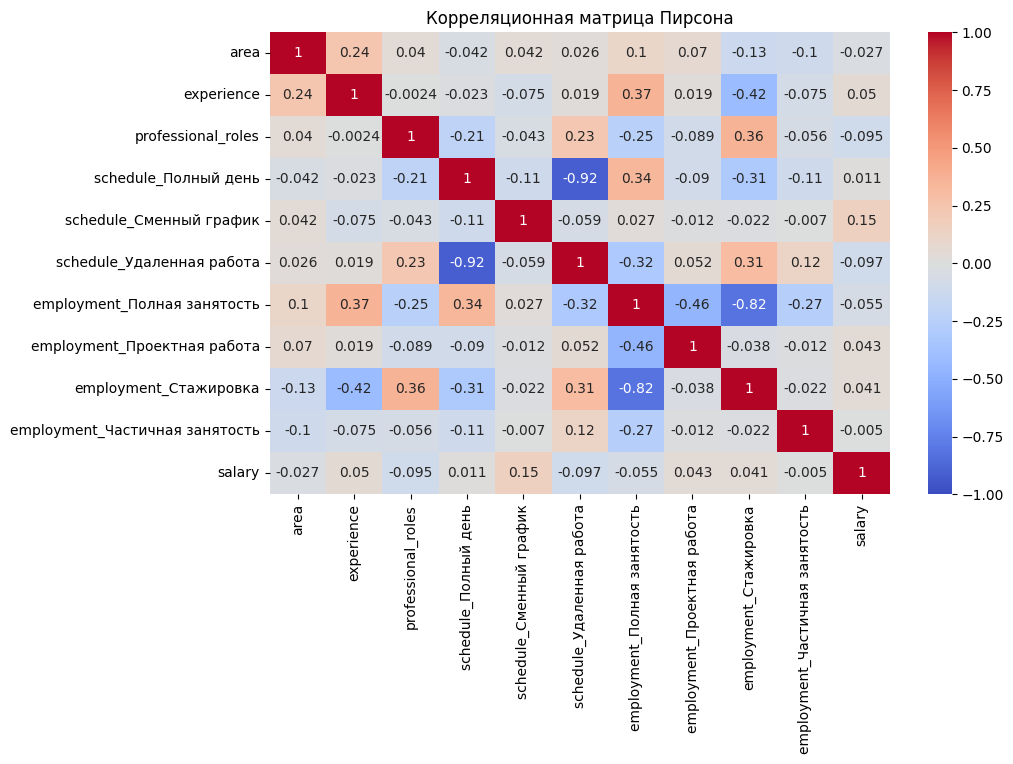

In [74]:
corr_matrix = for_corr.corr(method='pearson')

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляционная матрица Пирсона')
plt.show()

Коэффициент Спирмена устойчив к выбросам

Также как и в матрице Пирсона присутсвуют те же сильные линейные корреляции - признаки, исключающие друг друга.

Также коррелируют отрицательно (-0.46) experience и employment_Стажировка, employment_Полная занятость и employment_Проектная работа - пока один признак увеличивается, уменьшается другой, что логично



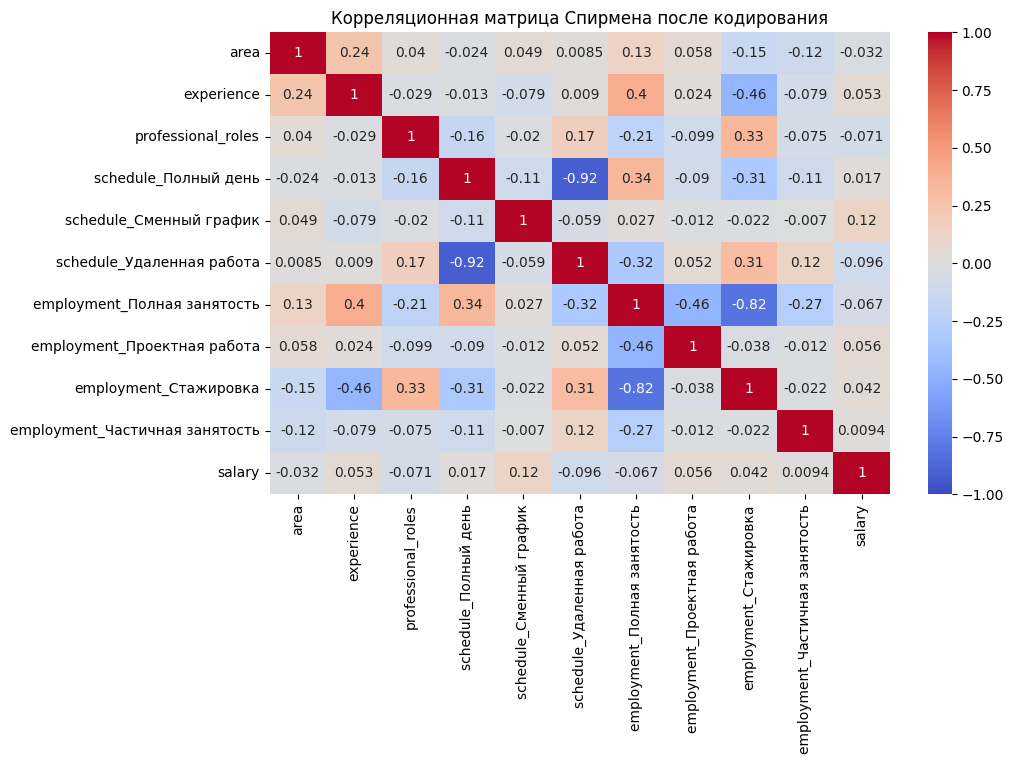

In [75]:
corr_matrix = for_corr.corr(method='spearman')

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Корреляционная матрица Спирмена после кодирования')
plt.show()

Матрица Фика фиксирует нелинейную зависимость


interval columns not set, guessing: ['area', 'experience', 'professional_roles', 'schedule_Полный день', 'schedule_Сменный график', 'schedule_Удаленная работа', 'employment_Полная занятость', 'employment_Проектная работа', 'employment_Стажировка', 'employment_Частичная занятость', 'salary']


<Axes: >

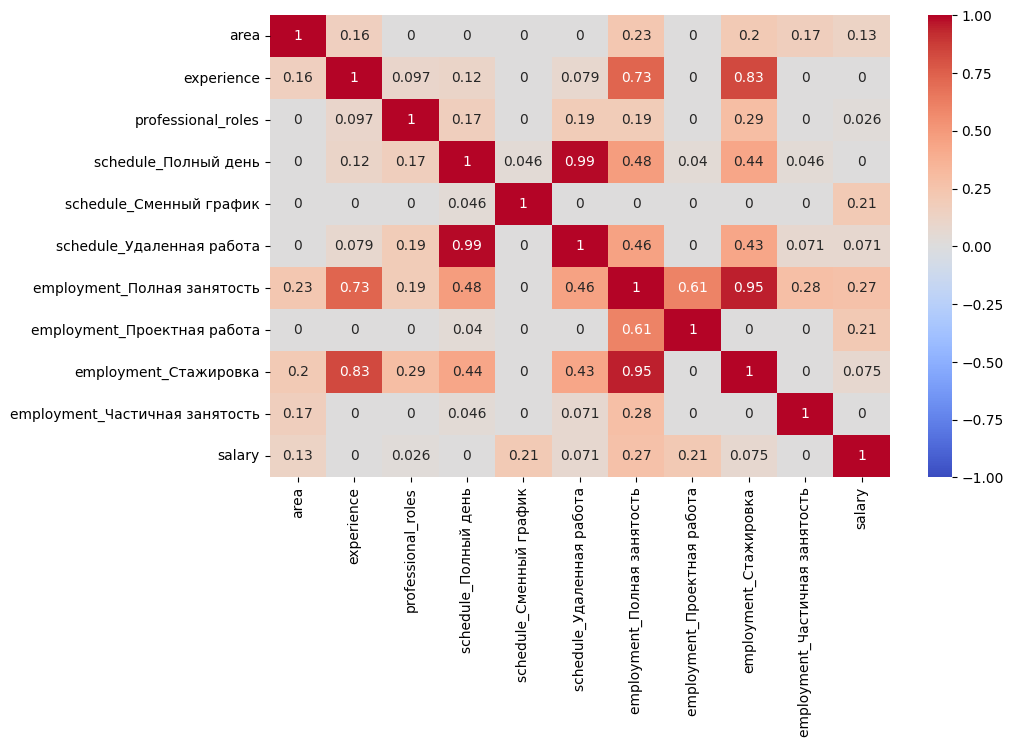

In [76]:
plt.figure(figsize=(10, 6))
sns.heatmap(for_corr.phik_matrix(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)

Коффициенты Спирмана (робастны к выбросам) и коэффициента Пирсона отлчаются от друг от друга максимум на сотые значения -> в данных отсутствуют выбросы

Разница в коэффициентах корреляции между матрицами Спирмена и Фика может указывать на наличие нелинейных зависимостей в данных.

Значительная разница между коэффициентами корреляции
в Спирмена: -0.46 и в Пфика: 0.83 между признаками employment_Стажировка и experience. Монотонная зависимость указывала: чем меньше опыт работы, тем выше вероятность, что человек окажется на стажировке. Высокая нелинейность может быть интерпретирована как резкое понижение вероятности нахождения на стажировке при повышении опыта;

в Спирмена: 0.4 и в Пфика: 0.73 между признаками employment_Полная_занятость и experience;
действительно указывает на наличие нелинейной зависимости между этими переменными.

Выявлена очень высокая нелинейная, сложная зависимость опыта, занятости, графика работы от навыков.

Сильная зависимость (0.95, 0.99) между признаками employment_Полная занятость и employment Стажировка, schedule_Полный день и schedule_Удаленная работа - признаки друг друга взаимоисключают


Остальные данные содержат слабую и умеренную нелинейность

Необходимо исключить пару признаков, взаимоисключающих друг друга


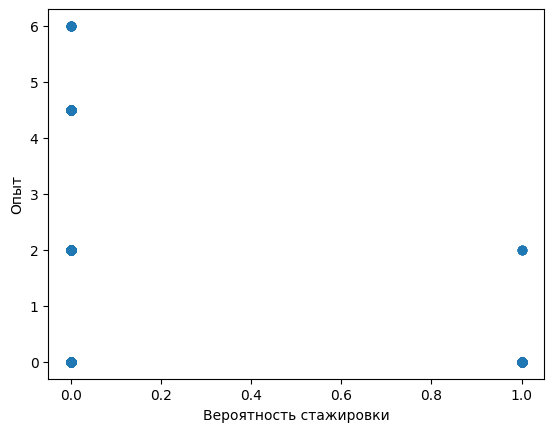

In [77]:
plt.scatter(X_train['employment_Стажировка'], X_train['experience'])
plt.xlabel('Вероятность стажировки')
plt.ylabel('Опыт')
plt.show()

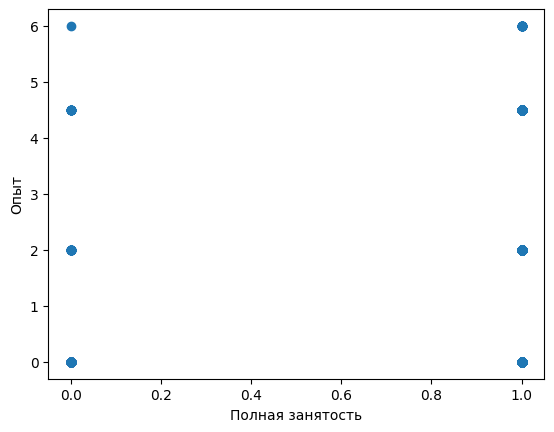

In [78]:
plt.scatter(X_train['employment_Полная занятость'], X_train['experience'])
plt.xlabel('Полная занятость')
plt.ylabel('Опыт')
plt.show()

In [79]:
def construct_features(X):
  X['experience^3'] = X['experience'] ** 3
  X['internship_experience'] = X['employment_Стажировка'] * X['experience']
  X['has_experience'] = (X['experience'] > 0).astype(int)
  return X

X_train = construct_features(X_train)
X_test = construct_features(X_test)

In [87]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

top_correlations = get_top_abs_correlations(X_train, 50)
print("Top Absolute Correlations")
print(top_correlations)

Top Absolute Correlations
experience                               experience^3                  0.898808
saas                                     внедрение продукта            0.816286
camunda                                  микросервисная архитектура    0.816076
draw.io                                  babok                         0.816038
waterfall                                http                          0.815113
scala                                    mlflow                        0.788150
system analysis                          json api                      0.786191
use cases                                wsdl                          0.774198
scala                                    hadoop                        0.765576
computer vision                          opencv                        0.755345
java                                     html                          0.751273
                                         бизнес-консультирование       0.751273
многозадачност

In [81]:
corr = X_train.corr()
highly_correlated = set()
corr_threshold = 0.85
for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > corr_threshold:
            colname = corr.columns[i]
            highly_correlated.add(colname)
print(*highly_correlated)

retail experience^3 db2 plc employment_Стажировка оптимизация численности персонала hr-аналитика scala it внедрение продукта schedule_Удаленная работа жизненный цикл по продуктовый анализ node.js


In [82]:
list_features = ['it', 'инфобизнес', 'оптимизация численности персонала',
                 'работа в режиме многозадачности', 'retail',
                 'employment_Полная занятость', 'schedule_Полный день',
                 'продуктовый анализ', 'жизненный цикл по', 'db2',
                 'менеджмент', 'apache spark', 'plc', 'node.js']
def delete_features(l, X):
  X = X.drop(l, axis=1)
  return X

X_train = delete_features(list_features, X_train)
X_test = delete_features(list_features, X_test)

Удалим константные и квазиконстантные признаки

In [83]:
selector = VarianceThreshold(threshold=0)
selector.fit_transform(X_train, y_train)
selector.transform(X_test)

selected_features = X_train.columns[selector.get_support()]

In [ ]:
selected_features

In [85]:
dropped_features = list(set(X_train.columns) - set(selected_features))
len(dropped_features)

43

In [86]:
X_train = pd.DataFrame(X_train, columns=selected_features)
X_test = pd.DataFrame(X_test, columns=selected_features)

 Выводы: необходимо было сконструировать новые фичи, для объяснения нелинейности модели, избегать даталиков. Главным образом на качество повлияли новые фичи и удаление сильно коррелирующих фичей. Все данные были подвергнуты преобразованию: среднее арифметическое от зарплаты и опыта работы, енкодинг локации, должностей, занятости и графика работы. Для данных,  коррелирующих нелинейно необходимо было сделать новые признаки (возведение в степень и т.д).  Навыки были отобраны и почищены,  чтобы проинтерпретировать вклад в предсказанный результат.

**Строим модели на данных**

Сравниваем статистики для X_train, X_test, y_train, y_test

In [ ]:
print("Train target mean:", np.mean(y_train))
print("Train target std:", np.std(y_train))
print("Train target median:", np.median(y_train))

print("Test target mean:", np.mean(y_test))
print("Test target std:", np.std(y_test))
print("Test target median:", np.median(y_test))

Train target mean: 136153.29417562982
Train target std: 68024.63367977201
Train target median: 115000.0
Test target mean: 135624.36933194153
Test target std: 67347.28152046831
Test target median: 115000.0


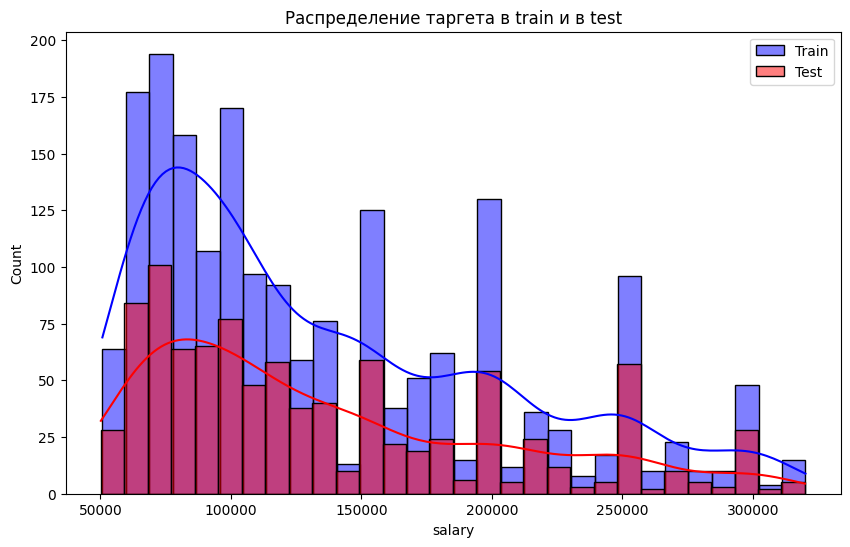

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(y_train, color="blue", label="Train", kde=True, bins=30)
sns.histplot(y_test, color="red", label="Test", kde=True, bins=30)
plt.title("Распределение таргета в train и в test")
plt.legend()
plt.show()

In [ ]:
model_rf = RandomForestRegressor(random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
train_preds = model_rf.predict(X_train)
test_preds = model_rf.predict(X_test)
train_evaluator = RegressionMetric(array(y_train), array(train_preds))
test_evaluator = RegressionMetric(array(y_test), array(test_preds))
print(f'MPE на трейне случайного леса {train_evaluator.mean_percentage_error()}')
print(f'MPE на тесте случайного леса {test_evaluator.mean_percentage_error()}')
print('-------------------------------------------------')
train_mae = mean_absolute_error(y_train, train_preds)
print(f'MAE случайного леса на трейне: {train_mae}')
test_mae = mean_absolute_error(y_test, test_preds)
print(f'MAE случайного леса на тeсте: {test_mae}')
print('-------------------------------------------------')
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f'RMSE случайного леса на трейне: {train_rmse}')
print(f'RMSE случайного леса на тесте: {test_rmse}')
print('-------------------------------------------------')
train_mape = mean_absolute_percentage_error(y_train, train_preds)
test_mape = mean_absolute_percentage_error(y_test, test_preds)
print(f'MAPE случайного леса на трейне: {train_mape}')
print(f'MAPE случайного леса на тесте: {test_mape}')
print('-------------------------------------------------')
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_preds))
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_preds))
print(f'RMSLE случайного леса на трейне: {train_rmsle}')
print(f'RMSLE случайного леса на тесте: {test_rmsle}')


MPE на трейне случайного леса -0.040654176358496386
MPE на тесте случайного леса -0.08814501196021353
-------------------------------------------------
MAE случайного леса на трейне: 13374.588766453728
MAE случайного леса на тeсте: 34071.07243905992
-------------------------------------------------
RMSE случайного леса на трейне: 19117.26096882234
RMSE случайного леса на тесте: 47682.3582286392
-------------------------------------------------
MAPE случайного леса на трейне: 0.10958164523784307
MAPE случайного леса на тесте: 0.2680252729464741
-------------------------------------------------
RMSLE случайного леса на трейне: 0.14558091678045001
RMSLE случайного леса на тесте: 0.3287868772564368


In [ ]:
model = CatBoostRegressor(random_state=42)
model.fit(X_train, y_train)

Learning rate set to 0.045481
0:	learn: 66656.6151139	total: 63.7ms	remaining: 1m 3s
1:	learn: 65441.0219366	total: 72.2ms	remaining: 36s
2:	learn: 64291.3208238	total: 85.6ms	remaining: 28.4s
3:	learn: 63218.4721518	total: 99.8ms	remaining: 24.8s
4:	learn: 62214.3218114	total: 104ms	remaining: 20.8s
5:	learn: 61266.4320131	total: 116ms	remaining: 19.2s
6:	learn: 60478.6108467	total: 121ms	remaining: 17.2s
7:	learn: 59734.9118203	total: 127ms	remaining: 15.8s
8:	learn: 58980.2849819	total: 146ms	remaining: 16.1s
9:	learn: 58279.5203052	total: 157ms	remaining: 15.5s
10:	learn: 57539.5474772	total: 178ms	remaining: 16s
11:	learn: 56878.6687706	total: 184ms	remaining: 15.2s
12:	learn: 56255.4062480	total: 201ms	remaining: 15.3s
13:	learn: 55664.8804487	total: 207ms	remaining: 14.6s
14:	learn: 55147.8539043	total: 213ms	remaining: 14s
15:	learn: 54689.5446330	total: 226ms	remaining: 13.9s
16:	learn: 54278.0473117	total: 242ms	remaining: 14s
17:	learn: 53851.4269593	total: 249ms	remaining: 

In [ ]:
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)
train_evaluator = RegressionMetric(array(y_train), array(train_preds))
test_evaluator = RegressionMetric(array(y_test), array(test_preds))
print(f'MPE на трейне бустинга {train_evaluator.mean_percentage_error()}')
print(f'MPE на тесте бустинга {test_evaluator.mean_percentage_error()}')
print('-------------------------------------------------')
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
print(f'MAE бустинга на трейне: {train_mae}')
print(f'MAE бустинга  на тeсте: {test_mae}')
print('-------------------------------------------------')
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f'RMSE бустинга на трейне: {train_rmse}')
print(f'RMSE бустинга на тесте: {test_rmse}')
print('-------------------------------------------------')
train_mape = mean_absolute_percentage_error(y_train, train_preds)
test_mape = mean_absolute_percentage_error(y_test, test_preds)
print(f'MAPE бустинга на трейне: {train_mape}')
print(f'MAPE бустинга на тесте: {test_mape}')
print('-------------------------------------------------')
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_preds))
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_preds))
print(f'RMSLE бустинга на трейне: {train_rmsle}')
print(f'RMSLE бустинга на тесте: {test_rmsle}')

MPE на трейне бустинга -0.07618965032809906
MPE на тесте бустинга -0.10131116712666673
-------------------------------------------------
MAE бустинга на трейне: 24523.166579938596
MAE бустинга  на тeсте: 34589.00949061481
-------------------------------------------------
RMSE бустинга на трейне: 32794.99458131811
RMSE бустинга на тесте: 46209.32561201763
-------------------------------------------------
MAPE бустинга на трейне: 0.20578732056549898
MAPE бустинга на тесте: 0.2827692239343127
-------------------------------------------------
RMSLE бустинга на трейне: 0.2477224285149668
RMSLE бустинга на тесте: 0.3341929040706303


In [88]:
best_loss = float('inf')
best_model_filename = "best_catboost_model.cbm"

def objective(trial):
    global best_loss

    param = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.02),
        'depth': trial.suggest_int('depth', 4, 10),  # Ограничение на глубину дерева
        'l2_leaf_reg': trial.suggest_uniform('l2_leaf_reg', 3.0, 10.0),  # Больше регуляризации
        'min_child_samples': trial.suggest_categorical('min_child_samples', [4, 8, 16, 32]),
        'grow_policy': 'Depthwise',
        'iterations': 8000,
        'use_best_model': True,
        'eval_metric': 'RMSE',
        'od_type': 'iter',
        'od_wait': 20,
        'random_state': 42,
        'logging_level': 'Silent'
    }

    regressor = CatBoostRegressor(**param)

    regressor.fit(X_train.copy(), y_train.copy(),
                  eval_set=[(X_train.copy(), y_train.copy())],
                  early_stopping_rounds=100)

    test_loss = root_mean_squared_error(y_test, regressor.predict(X_test.copy()))


    if test_loss < best_loss:
        best_loss = test_loss
        regressor.save_model(best_model_filename)
        print(f"New best model saved with test loss: {best_loss}")

    return test_loss


Для подбора гиперпараметров библиотека Optuna

In [ ]:
%%time
study = optuna.create_study(study_name='catboost-seed42')
study.optimize(objective, n_trials=500, n_jobs=-1, timeout=3600)

In [90]:
print(study.best_value)
print(study.best_params)

45952.48048473685
{'learning_rate': 0.0035673697186877048, 'depth': 10, 'l2_leaf_reg': 5.757395115422895, 'min_child_samples': 4}


In [ ]:
model_hyper = CatBoostRegressor(**study.best_params, iterations=10000, early_stopping_rounds=100, random_state=42)
model_hyper.fit(X_train, y_train)
model_hyper.save_model('cb_super',
           format="cbm",
           export_parameters=None,
           pool=None)

In [94]:
train_preds = model_hyper.predict(X_train)
test_preds = model_hyper.predict(X_test)
train_evaluator = RegressionMetric(array(y_train), array(train_preds))
test_evaluator = RegressionMetric(array(y_test), array(test_preds))
print(f'MPE на трейне бустинга {train_evaluator.mean_percentage_error()}')
print(f'MPE на тесте бустинга {test_evaluator.mean_percentage_error()}')
print('-------------------------------------------------')
train_mae = mean_absolute_error(y_train, train_preds)
test_mae = mean_absolute_error(y_test, test_preds)
print(f'MAE бустинга на трейне: {train_mae}')
print(f'MAE бустинга  на тeсте: {test_mae}')
print('-------------------------------------------------')
train_rmse = root_mean_squared_error(y_train, train_preds)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f'RMSE бустинга на трейне: {train_rmse}')
print(f'RMSE бустинга на тесте: {test_rmse}')
print('-------------------------------------------------')
train_mape = mean_absolute_percentage_error(y_train, train_preds)
test_mape = mean_absolute_percentage_error(y_test, test_preds)
print(f'MAPE бустинга на трейне: {train_mape}')
print(f'MAPE бустинга на тесте: {test_mape}')
print('-------------------------------------------------')
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_preds))
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_preds))
print(f'RMSLE бустинга на трейне: {train_rmsle}')
print(f'RMSLE бустинга на тесте: {test_rmsle}')

MPE на трейне бустинга -0.07183131743330735
MPE на тесте бустинга -0.10015692503900071
-------------------------------------------------
MAE бустинга на трейне: 22810.88799433348
MAE бустинга  на тeсте: 33710.37269395602
-------------------------------------------------
RMSE бустинга на трейне: 30767.38723090268
RMSE бустинга на тесте: 45403.582226898005
-------------------------------------------------
MAPE бустинга на трейне: 0.19123880818066502
MAPE бустинга на тесте: 0.2734864200380937
-------------------------------------------------
RMSLE бустинга на трейне: 0.2331482552212974
RMSLE бустинга на тесте: 0.32335398745034555


**Анализ результатов**

При преобразовании признаков experience метрики улучшились.Убраны дата лики -> ситуация с переобучением улучшилась. Убраны константные признаки. До преобразований и консутрирования новых признаков результаты лучшей модели с гиперпараметрами составляли: RMSE на тесте 48692, а MAPE 0.297

Наилучшие метрики из всех экспериментов

**RMSE на трейне:** 30767.3872

**RMSE на тесте:** 45403.5822

RMSE - более чувствительная метрика к большим ошибкам, чем MAE. Аналогично MAE, RMSE на тесте значительно выше, чем на трейнере, что говорит о плохой обобщающей способности модели.

**MAPE на трейне:** 0.1912

**MAPE на тесте:** 0.2735

MAPE показывает средний процент ошибки прогнозирования. Значительное увеличение MAPE на тестовых данных по сравнению с тренировочными также подтверждает проблемы с обобщением модели.

1. RMSE (Root Mean Squared Error) - основная метрика

Выбор RMSE в качестве основной метрики обусловлен несколькими факторами:

* Чувствительность к ошибкам: RMSE более чувствительна к большим ошибкам, чем MAE. Это важно, если большие ошибки имеют серьезные последствия. Например, в прогнозировании цен на недвижимость большая ошибка может привести к значительным финансовым потерям.
* Масштабируемость: RMSE имеет тот же масштаб, что и исходные данные. Это делает ее более понятной и сравнимой с другими показателями.
* Интуитивность: RMSE легко интерпретировать как среднюю ошибку прогнозирования в масштабе исходных данных.

2. MAPE (Mean Absolute Percentage Error) - для интерпретации RMSE

MAPE дополняет RMSE, помогая интерпретировать ее результаты:

* Процентная ошибка: MAPE показывает среднюю процентную ошибку прогнозирования. Это помогает понять, насколько велика ошибка относительно фактического значения. Например, если RMSE = 10000, но MAPE = 5%, то это означает, что ошибка составляет 5% от фактического значения.
* Сравнение разных моделей: MAPE позволяет сравнивать качество разных моделей, даже если они прогнозируют разные значения.

Почему не выбраны другие метрики:

* MPE (Mean Percentage Error): MPE чувствительна к выбросам, и ее значения могут быть сильно искажены, если есть несколько больших ошибок.
* MAE (Mean Absolute Error): MAE не так чувствительна к большим ошибкам, как RMSE.
* RMSLE (Root Mean Squared Logarithmic Error): RMSLE полезен для 'перепрогноза'. Перепрогноз зарплат может вызвать положительную эмоцию у пользователей, однако при несоотсветствии зарплат на рынке и в продукте, пользователи перестанут доверять продукту

Выводы:

Метрики улучшились, однако все еще демонстрируют плохую обобщаемость модели


In [95]:
model_load = CatBoostRegressor()
model_load.load_model('/content/cb_super')

Получаем вклад каждого признака в результат

In [98]:
explainer = shap.Explainer(model_load)
shap_values = explainer(X_test)

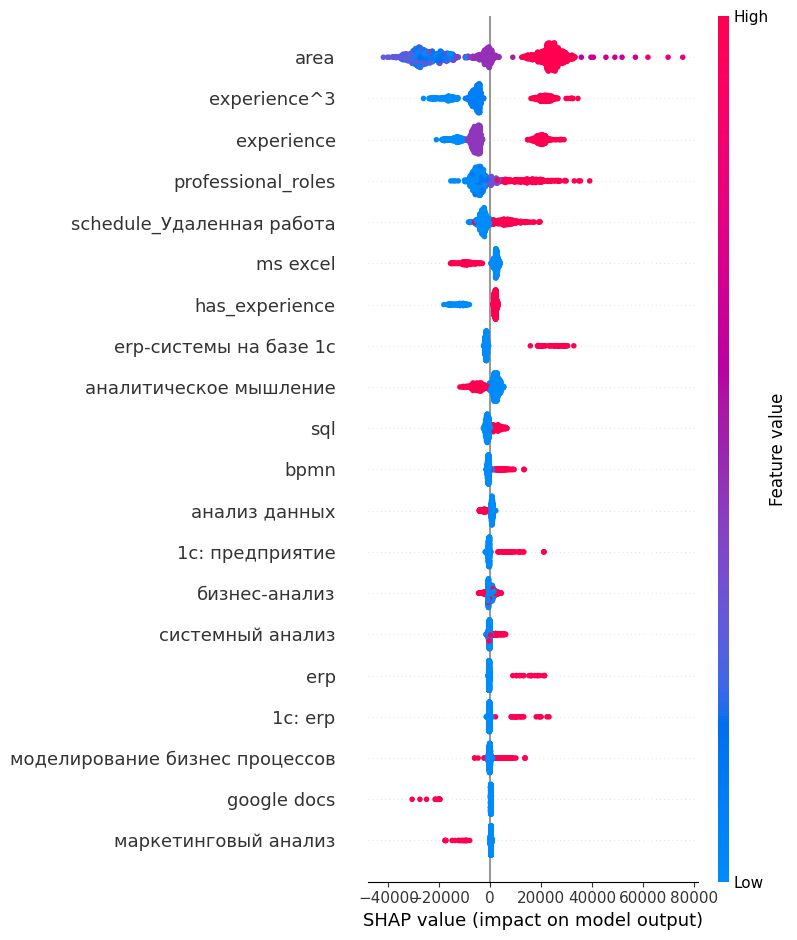

In [99]:
shap.summary_plot(shap_values, X_test)

Видим, что самыми значимыми признаками, которые оказывают наибольшее влияние на предсказания модели, являются: area, experience, experience^3

In [100]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

In [101]:
shap_values_df

,area,experience,professional_roles,dax,scada,ui/ux,idef0,разработка проектной документации,1с:erp,deep learning,...,автоматизация процессов,schedule_Гибкий график,schedule_Сменный график,schedule_Удаленная работа,employment_Проектная работа,employment_Стажировка,employment_Частичная занятость,experience^3,internship_experience,has_experience
0,25533.450007,-6648.368501,-7330.175415,-52.959169,0.189039,-31.899000,-289.731148,44.270384,-0.608728,28.968226,...,-21.910054,-85.478565,9.028168,-1839.208910,-2.007366,224.248635,364.997550,-6613.524556,131.265424,2186.679422
1,-393.214649,-4802.237042,-7327.836075,-36.229138,0.058641,-35.382650,-196.108185,34.847085,-0.506688,19.248148,...,-40.509127,-163.729101,6.524095,-3230.131170,-50.002408,167.597008,223.384087,-4489.663909,103.186592,1840.125788
2,18850.770915,-18680.189023,1311.134743,-51.618904,0.133956,-34.603631,-95.467823,42.996073,-1.127381,29.543772,...,-51.318407,-90.734781,5.268271,-1797.841440,-5.251270,250.066065,287.562092,-23418.404892,124.618382,-16126.744186
3,-28998.367128,18160.167198,-5127.026454,-33.168710,0.191224,-33.538817,-335.330421,39.078761,-0.400230,17.160621,...,-46.163978,-133.814511,8.424863,-5706.686833,-81.399623,208.962292,214.629145,19021.758223,101.486204,1543.154054
4,-24704.344750,-4084.974159,-3944.835437,-37.460613,-0.056903,-35.508502,-321.336603,38.898999,-0.825962,16.304691,...,-59.920466,-130.482761,5.641738,-2443.238103,-130.690350,135.342286,228.036835,-4137.700698,102.716358,1604.155626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,3349.826918,-14908.253593,-4151.508716,-35.709561,2.232139,-34.191149,-212.046627,41.178805,4.474540,20.486917,...,-41.538332,-277.935853,4.311457,-2453.354257,-43.912230,149.522139,217.676036,-18410.292517,107.840059,-13595.201533
954,26217.361031,20482.991975,-1348.937719,-38.980730,0.836937,-31.934932,-106.307231,50.809713,-0.375166,30.962605,...,-10.501742,-180.785385,10.929796,-1718.230644,14.992887,224.620761,706.749960,22277.803288,130.584661,2278.400729
955,-18822.171938,-4639.126725,-3320.299105,-21.120334,-0.206017,-35.188837,-272.509926,29.015509,-1.119158,25.025196,...,-124.342199,-130.288709,0.893184,4520.503383,74.781190,66.694755,207.114416,-4734.405287,79.037000,1461.212700
956,26035.306750,22331.972882,-2639.879571,-8.425160,0.603348,-29.629103,-186.317805,49.661067,-0.387553,45.101379,...,11.009831,-91.526918,10.450172,7010.974211,111.801812,248.120193,402.867992,24254.334593,108.337726,2298.109083
